Adam Prado
Pace U. Data Science 
4/1/24

Chapter 6, Applied #8

Importing the libraries, probably more than I used, I just grabbed them all from the Lab examples to be safe.

In [67]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from l0bnb import fit_path

import statsmodels.api as sm 


a) Creates 100 random predictor variables, X, and 100 noise values.

In [68]:
np.random.seed(1)
X = np.random.normal(0,1,100)
noise = np.random.normal(0,1,100)
X

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
       -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
       -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
       -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
       -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
       -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
       -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
        0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
        0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
       -0.75439794,  1.25286816,  0.51292982, -0.29809284,  0.48851815,
       -0.07557171,  1.13162939,  1.51981682,  2.18557541, -1.39

b) Generate a response vector 'Y' using a cubic function with an intercept of 6 and coefficients of 5, 4, and 3 as well as added noise value.

In [69]:
Y = 6 + 5*X + 4*(X**2) + 3*(X**3) + noise
Y

array([ 3.70860850e+01,  4.97586727e+00,  4.43646955e+00,  2.12797914e+00,
        1.41722379e+01, -2.07242959e+01,  4.35776354e+01,  2.23479676e+00,
        7.83354184e+00,  4.98798328e+00,  2.98653668e+01, -1.32396476e+01,
        5.54933748e+00,  3.64026182e+00,  2.15332803e+01,  3.54874338e-02,
        5.20270976e+00,  1.04795084e+00,  7.33984012e+00,  1.12755717e+01,
        1.31799082e+00,  2.06901381e+01,  1.72317897e+01,  1.18702160e+01,
        1.40857095e+01,  4.72856481e+00,  7.06803999e+00,  2.70356223e+00,
        3.69067348e+00,  1.10877606e+01,  3.28169402e+00,  3.85460226e+00,
        2.24944177e+00,  3.37062440e+00,  4.33152882e+00,  5.31378175e+00,
        1.74306248e+00,  6.28618391e+00,  3.98386275e+01,  1.31850805e+01,
        4.98027683e+00,  2.51360091e+00,  4.11478345e+00,  4.12139089e+01,
        6.79422328e+00,  3.80036813e+00,  7.19906932e+00,  6.25570701e+01,
        6.89624664e+00,  1.19976771e+01,  7.63228175e+00,  2.16911139e+00,
        2.07347398e+00,  

c)
I set up a dateframe with predictors for X, X^2, ...X^10, named X1,X2...x10

In [70]:
data = pd.DataFrame({'X': X, 'Y': Y})
data.shape

(100, 2)

In [71]:
for i in range(2, 11):
    data[f'X{i}'] = data['X'] ** i

In [72]:
data[:1]

,X,Y,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.624345,37.086085,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436


Define function for measuring Cp (as a negative )

In [73]:
def nCp (sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n,p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS+2*p*sigma2)/n

In [74]:

design = MS(data.columns.drop('Y')).fit(data)
Y = np.array(data['Y'])
X = design.transform(data)
sigma2 = OLS(Y,X).fit().scale

In [75]:
neg_Cp = partial(nCp, sigma2)

In [76]:
strategy = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))


In [77]:
data_MSE = sklearn_selected(OLS, strategy)
data_MSE.fit(data, Y)
data_MSE.selected_state_

('X', 'X10', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9')

c) Then selects the variables for the model.

In [78]:
data_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
data_Cp.fit(data, Y)
data_Cp.selected_state_  


('X', 'X2', 'X3', 'X6')

Use the variables to constuct an model with coefficients. 

In [79]:
X = sm.add_constant(data[['X', 'X2', 'X3','X6']])
Y = data['Y']

model = OLS(Y, X).fit()


model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     4813.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):          1.03e-108
Time:                        22:17:32   Log-Likelihood:                -130.61
No. Observations:                 100   AIC:                             271.2
Df Residuals:                      95   BIC:                             284.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2769      0.128     49.085      0.000       6.023       6.531
X              4.9101      0.183     26.897      0.000       4.548       5.272
X2             3.6575      0.172     21.293      0.000       3.316       3.998
X3             3.1054      0.064     48.423      0.000       2.978       3.233
X6             0.0209      0.009      2.443      0.016       0.004       0.038
==============================================================================
Omnibus:                        1.527   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.466   Jarque-Bera (JB):                1.076
Skew:                          -0.236   Prob(JB):                        0.584
Kurtosis:                       3.187   Cond. No.                         50.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
fullpath =sklearn_selection_path(OLS,strategy)



In [81]:
fullpath.fit(data, Y)
Yhat_in = fullpath.predict(data)
Yhat_in.shape


(100, 11)

/var/folders/k3/m63gb3f97r94svg8h31wq40m0000gp/T/ipykernel_46543/3276190130.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)


(0.0, 300.0)

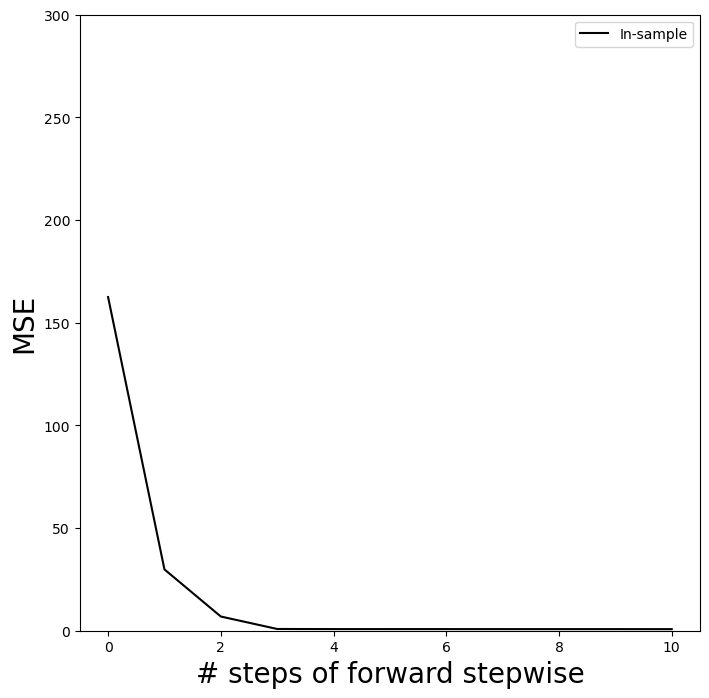

In [82]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),insample_mse, 'k', label ="In-sample")
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0,300])

In [83]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(fullpath, data, Y, cv=kfold)
Yhat_cv.shape

(100, 11)

In [84]:
cv_mse=[]
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx]-Y[test_idx, None])**2
    cv_mse.append(errors.mean(0))
cv_mse = np.array(cv_mse).T
cv_mse.shape

/var/folders/k3/m63gb3f97r94svg8h31wq40m0000gp/T/ipykernel_46543/649422207.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  errors = (Yhat_cv[test_idx]-Y[test_idx, None])**2


(11, 5)

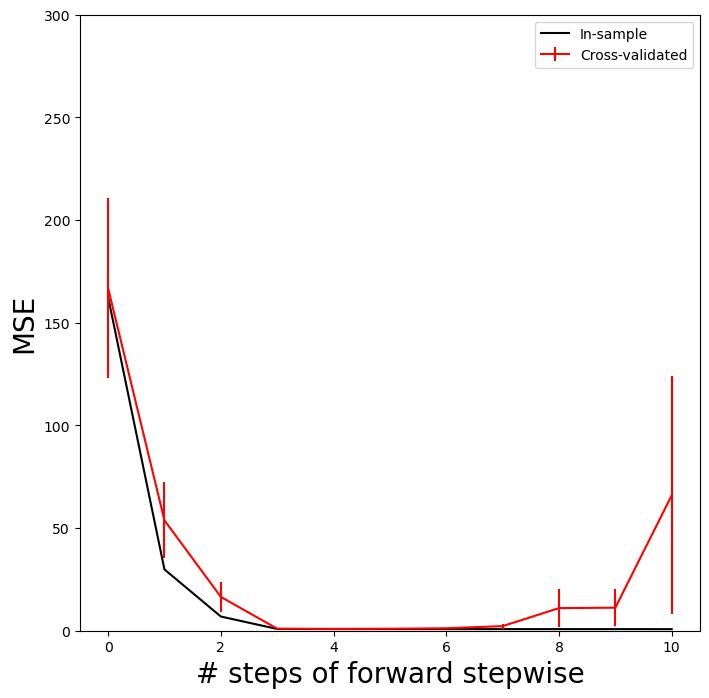

In [85]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1)/np.sqrt(K), label="Cross-validated", c="r")
ax.set_ylim([0,300])
ax.legend()
mse_fig

In [86]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_idx, test_idx in validation.split(Y):
    fullpath.fit(data.iloc[train_idx],Y[train_idx])
    Yhat_val = fullpath.predict(data.iloc[test_idx])
    errors =(Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)

/var/folders/k3/m63gb3f97r94svg8h31wq40m0000gp/T/ipykernel_46543/385412285.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  errors =(Yhat_val - Y[test_idx,None])**2


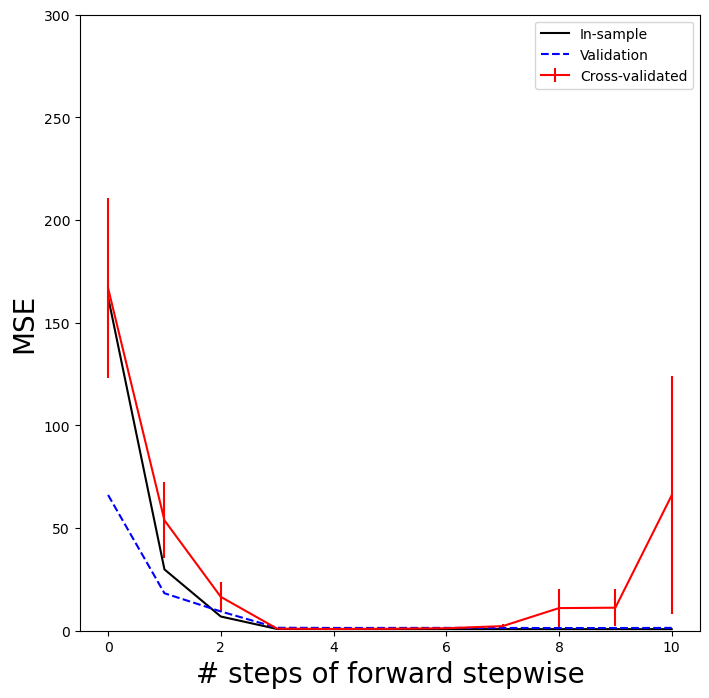

In [87]:
ax.plot(np.arange(n_steps), validation_mse, 'b--', label="Validation")
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([0,300])
ax.legend()
mse_fig

In [88]:
D = design.fit_transform(data)
D = D.drop('intercept',axis=1)
X = np.asarray(D)

In [92]:
path = fit_path(X,Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /Users/staff/anaconda3/lib/python3.11/site-packages/l0bnb/relaxation/_coordinate_descent.py (9)[0m
[1m
File "../anaconda3/lib/python3.11/site-packages/l0bnb/relaxation/_coordinate_descent.py", line 9:[0m
[1m
[1m@njit(cache=True)
[0m[1m^[0m[0m 

This error may have been caused by the following argument(s):
- argument 11: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m 

This error may have been caused by the following argument(s):
- argument 11: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m 

This error may have been caused by the following argument(s):
- argument 11: [1mCannot determine Numba type of <class 'pandas.core.series.Series'>[0m


In [ ]:
path[2]

{'B': array([5.05078476, 3.94101009, 2.97904199, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'B0': 6.199077236259481,
 'lambda_0': 0.0075970786775854575,
 'M': 1.051770741314611,
 'Time_exceeded': False}

In [ ]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path=sklearn_selection_path(OLS,strategy)
full_path.fit(data, Y)
Yhat_in = full_path.predict(data)





e) This is where I started the lasso model but I kept getting errors or unexpected results and could never get it to produce the model coefficients. 

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler',scaler),('lasso',lassoCV)])
pipeCV.fit(X,Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.011517267917597395

In [ ]:
# Xs = X - X.mean(0)[None,:]
lambdas, soln_array = skl.Lasso.path(X, Y, l1_ratio=1,n_alphas=100)[:2]

/Users/staff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.709576799568822, tolerance: 2.6296718827105736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/staff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.677044716465389, tolerance: 2.6296718827105736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/staff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.376499153339864, tolerance: 2.6296718827105736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/staff/anaconda3/lib/python3.11/site-packages/sklearn/li